In [1023]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA
from sklearn import random_projection as RP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve


import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False

In [642]:
df = pd.read_csv("data/cancer/breast-cancer.csv", index_col="id")

In [643]:
df = df.drop(columns='Unnamed: 32')

In [644]:
df.shape

(569, 31)

# Exploratory Data Analysis

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

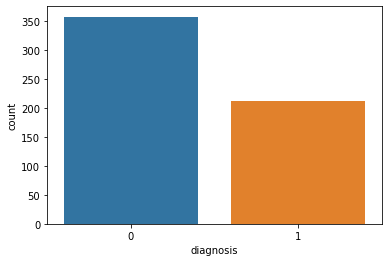

In [645]:
diagnosis_map = {'B':0, 'M':1}
df['diagnosis'] = df['diagnosis'].map(diagnosis_map)

sns.countplot(x=df['diagnosis'])

# Split data

In [646]:
x = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [647]:
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [648]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [649]:
print(f"train set size: {x_train.shape}")
print(f"test set size: {x_test.shape}")

train set size: (455, 30)
test set size: (114, 30)


# Scale

In [650]:
scaler = StandardScaler()

In [651]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.fit_transform(x_test)

In [652]:
print(np.min(x_train_sc))
print(np.max(x_train_sc))

-3.176344188780568
11.731855390439586


In [653]:
mm_scaler = MinMaxScaler()

In [654]:
x_train_mm = mm_scaler.fit_transform(x_train)
x_test_mm = mm_scaler.fit_transform(x_test)

In [655]:
print(np.min(x_train_mm))
print(np.max(x_train_mm))

0.0
1.0


### Helper methods

In [1156]:
def get_countplot(x, y, model, title, save_as):
    cluster = model.predict(x)
    df = pd.DataFrame(x)
    df["Cluster"] = cluster
    df["Label"] = y.values
    
#     sns.countplot(data = df[["Cluster", "Label"]], x = "Cluster" , hue = "Label", linewidth=1)
    sns.countplot(data = df[["Label", "Cluster"]], x = "Label" , hue = "Cluster", linewidth=1)
    plt.title(title)
    plt.savefig(save_as)
    plt.show()
    
#     sns.countplot(data = df[["cluster", "label"]], x = "cluster", linewidth=1)
#     plt.show()
    

# 1) Run Clustering

- 1.1) K-means
- 1.2) EM

## 1.1) K-Means

In [817]:
def kmeans_inertia(x_train_sc):
    """
    inertia = sum_of_squared_distances
    """
    kmeans_inertia = []
    K = range(1,15)
    
    for k in K:
        km = KMeans(n_clusters=k, random_state=0)
        km = km.fit(x_train_sc)
        kmeans_inertia.append(km.inertia_)  
        
    return kmeans_inertia

In [818]:
kmeans_inertia_df = kmeans_inertia(x_train_sc)

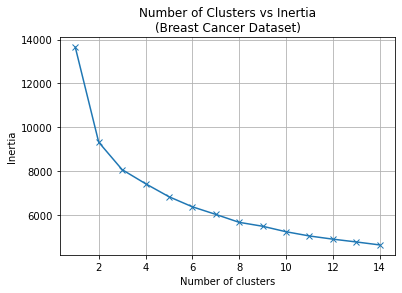

In [866]:
plt.plot(K, kmeans_inertia_df, 'x-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Number of Clusters vs Inertia\n(Breast Cancer Dataset)')

plt.grid()
plt.savefig('images/bc/1.1 Kmeans Inertia.png')
plt.show()

In [656]:
# As the number of clusters increases, the score is decreasing. 
#This is because the samples will be closer to the centroids they are assigned to.

# The idea behind the elbow method is to identify the value of k where the score 
# begins to decrease most rapidly before the curve reached a plateau

In [336]:
# Silhouette Score: This is a better measure to decide the number of clusters to be formulated from the data. 
# It is calculated for each instance and the formula goes like this:
# Silhouette Coefficient = (x-y)/ max(x,y)

# consider two measures:
#   The mean distance between a sample and all other points in the same cluster.
#   The mean distance between a sample and all other points in the next nearest cluster.
# i.e. it checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is

# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

In [1132]:
def kmeans_sil_score(x_train_sc):
    n_clusters=np.arange(2, 10)
    data=[]
    # data.append([1, 0])

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_train_sc)
        labels = km.predict(x_train_sc)
        sil = silhouette_score(x_train_sc, labels, metric='euclidean')

        print(n, sil)
        data.append([n, sil])

    kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return kmeans_sil_df

In [1133]:
kmeans_sil_df = kmeans_sil_score(x_train_sc)

2 0.3542973776417595
3 0.3176880400662849
4 0.17265338956946089
5 0.17390460493764365
6 0.1761256515839104
7 0.15433278114298885
8 0.14374047752120792
9 0.14042551091026065


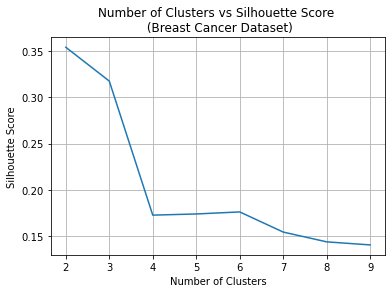

In [1138]:
plt.title("Number of Clusters vs Silhouette Score \n (Breast Cancer Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"])

plt.grid()
plt.savefig('images/bc/1.1 Kmeans sil score.png')
plt.show()

In [1479]:
def kmeans_pairplot(x_train_sc, y_train, title, save_as):
    km = KMeans(n_clusters=4, random_state=1)
    labels = km.fit_predict(x_train_sc)
    
#     plt.scatter(x_train_sc[:, 0], x_train_sc[:, 3], c=labels, s=10, cmap='viridis');

    data = pd.DataFrame(x_train_sc)
    data = data.iloc[:, :4]
    
    data["labels"] = labels
    
    sns.pairplot(data, hue="labels", palette='tab10')
#     sns.color_palette("tab20")
    plt.show()
    
    get_countplot(x_train_sc, y_train, km, title, save_as)
    
    clustering_accuracy = accuracy_score(labels, y_train)
    print(f"clustering_accuracy = {clustering_accuracy}")

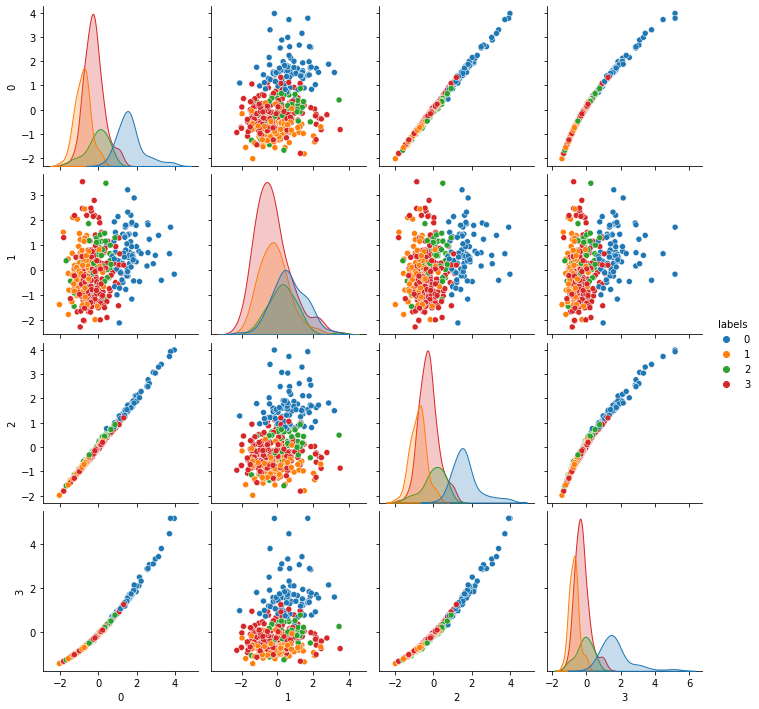

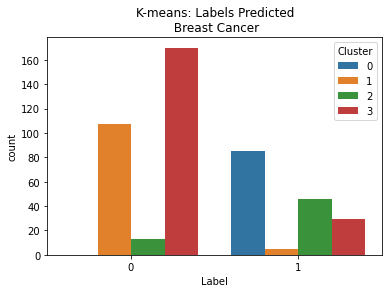

clustering_accuracy = 0.01098901098901099


In [1480]:
kmeans_pairplot(x_train_sc, y_train, title="K-means: Labels Predicted\n Breast Cancer", save_as="images/bc/1.2 labels kmean bc.png")

## 1.2) EM

In [1135]:
def em_sil_score(x_train_sc):
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_train_sc)
        labels = gmm.predict(x_train_sc)
        sil = silhouette_score(x_train_sc, labels, metric='euclidean')

        print(n, sil)
        data.append([n, sil])

    em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return em_sil_df
    

In [1136]:
em_sil_df = em_sil_score(x_train_sc)

2 0.31906399623655474
3 0.2807404286955553
4 0.1463097222179641
5 0.1133953623598196
6 0.13966465669075445
7 0.12919642867867115
8 0.12555169839340435
9 0.12354873923945751


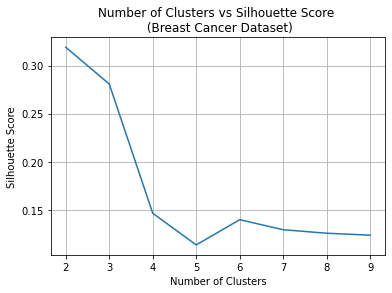

In [1137]:

plt.title("Number of Clusters vs Silhouette Score \n (Breast Cancer Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"])

plt.grid()
plt.savefig('images/bc/1.2 EM sil score.png')
plt.show()

In [339]:
### BIC
# Bayesian information criterion (BIC)
# how much is good the GMM in terms of predicting the data we actually have. 
# The lower is the BIC, the better is the model to actually predict the data we have

In [814]:
def em_bic_score(x_train_sc):
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_train_sc)
        labels = gmm.predict(x_train_sc)
        bic = gmm.bic(x_train_sc)

        data.append([n, bic])

    em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    return em_bic_df
    

In [815]:
em_bic_df = em_bic_score(x_train_sc)

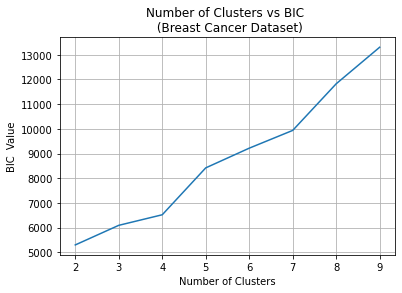

In [871]:

plt.title("Number of Clusters vs BIC \n (Breast Cancer Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC  Value") 
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"])

plt.grid()
plt.savefig('images/bc/1.2 EM BIC score.png')
plt.show()

In [880]:
# def em_plot(x_train_sc):
#     gmm = GaussianMixture(n_components=2, random_state=0)
#     labels = gmm.fit_predict(x_train_sc)
#     plt.scatter(x_train_sc[:, 0], x_train_sc[:, 1], c=labels, s=10, cmap='viridis');

In [1153]:
# em_plot(x_train_sc)

In [1485]:
def em_pairplot(x_train_sc, y_train, title, save_as):
    gmm = GaussianMixture(n_components=4, random_state=2)
    labels = gmm.fit_predict(x_train_sc)
    
#     plt.scatter(x_train_sc[:, 0], x_train_sc[:, 3], c=labels, s=10, cmap='viridis');

    data = pd.DataFrame(x_train_sc)
    data = data.iloc[:, :4]
    
    data["labels"] = labels
    
    sns.pairplot(data, hue="labels", palette='tab10')
    plt.show()
    
    get_countplot(x_train_sc, y_train, gmm, title, save_as)
    
    clustering_accuracy = accuracy_score(labels, y_train)
    print(f"clustering_accuracy = {clustering_accuracy}")

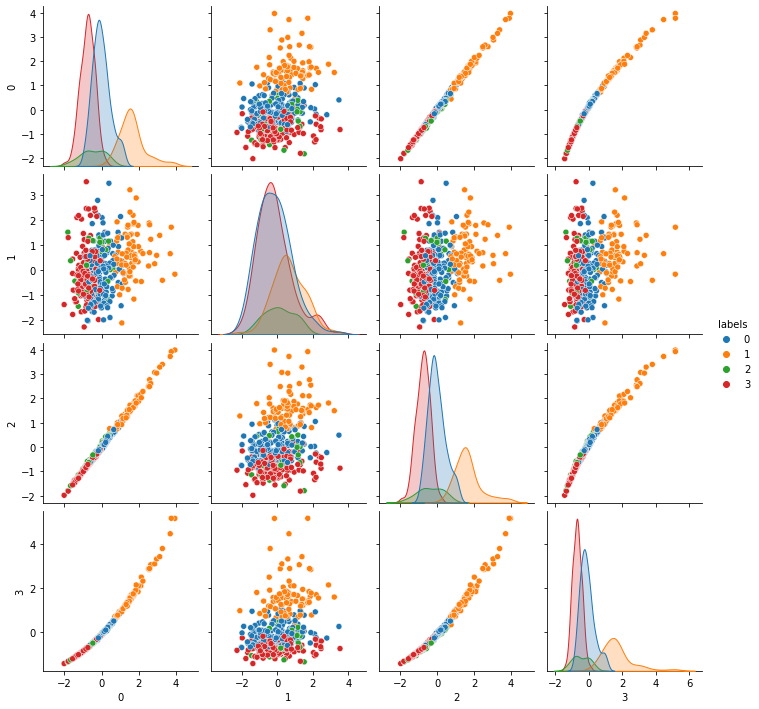

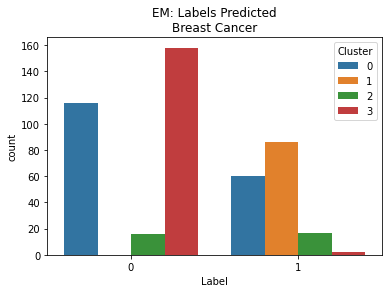

clustering_accuracy = 0.44395604395604393


In [1486]:
em_pairplot(x_train_sc, y_train, title="EM: Labels Predicted\nBreast Cancer", save_as="images/wq/1.2 labels kmean bc.png")

# 2) Dimensionality reduction

## 2.1) PCA

In [691]:
def pca_get_num_componenets_to_retain_variance(x_train):
    retain_variance = 0.90

    pca = PCA(retain_variance)
    principalComponents = pca.fit(x_train)

    comp_num = pca.n_components_

    print(f"{comp_num} components to retain {retain_variance} variance")

In [690]:
pca_get_num_componenets_to_retain_variance(x_train_sc)

7 components to retain 0.9 variance


In [829]:
def pca_plot_pc(x_train, y_train):
    pca = PCA(n_components=7)
    principalComponents = pca.fit_transform(x_train)
    
    columns = []
    for i in range(comp_num):
        columns.append(f"principal component {i+1}")

    print(columns)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = columns)
    
    principalDf['diagnosis'] = y_train.values
    
    
    fig = plt.figure(figsize = (8,8))

    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('PCA: Visualization')

    diagnosis = [0, 1]
    colors = ['r', 'g']

    for target, color in zip(diagnosis, colors):
        indicesToKeep = principalDf['diagnosis'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)

        ax.legend(diagnosis)
    
    plt.savefig('images/bc/2.1 pc1 vs pc2.png')
    ax.grid()
    
    print("Explained variation per principal component:\n")
    print(pca.explained_variance_ratio_)
    
    np.sum(pca.explained_variance_ratio_)

['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7']
Explained variation per principal component:

[0.43430767 0.19740115 0.09351771 0.06677661 0.05642452 0.04071619
 0.02149254]


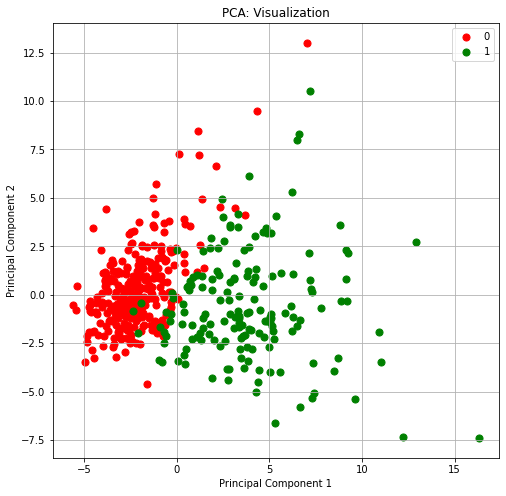

In [830]:
pca_plot_pc(x_train_sc, y_train)

In [344]:
# The explained variance tells you how much information (variance) can be 
# attributed to each of the principal components

In [994]:
def run_pca(x_train):
    """
    Run PCA and plot variance retained for each number of components
    """
    
    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1): 
        pca = PCA(n_components=num)
        principalComponents = pca.fit_transform(x_train)
        
        variance_retained = np.sum(pca.explained_variance_ratio_)
        
        data.append([num, variance_retained])
        
    df = pd.DataFrame(data, columns=["Features", "Explained Variance Ratio"])
    
    plt.title("Number of Components vs Explained Variance \n (Breast Cancer Dataset)")
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance Ratio") 
    plt.plot(df["Features"], df["Explained Variance Ratio"])
    
    plt.axhline(0.9, linestyle="dotted", color='g')
    plt.axvline(6.6, linestyle="dotted", color='g')
    
    plt.grid()
    plt.savefig('images/bc/2.1 pca variance retained.png')
    plt.show()

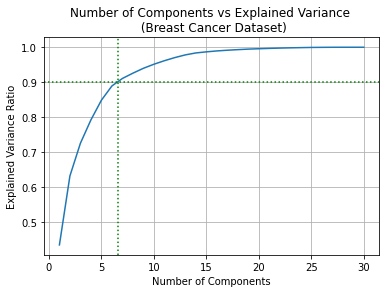

In [995]:
run_pca(x_train_sc)

In [353]:
# 7 features to retain 90% of the variance

In [1000]:
def run_pca_plot_eigen_values(x_train):
    n = x_train_sc.shape[1]
    data = []
    BARS_TO_SHOW = 10
    
    pca = PCA(n_components=n)
    pca.fit(x_train)
    
    variance = pca.explained_variance_ratio_
    variance = np.round(variance, decimals=3) * 100
    print(variance)
    
    x_labels = range(1, n+1)
    y_values = variance
    
    bars = plt.bar(x_labels[:BARS_TO_SHOW], y_values[:BARS_TO_SHOW], width=0.5)
    
    plt.title("Principal Component vs Explained Variance \n (Breast Cancer Dataset)")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio") 
    
    plt.xticks(x_labels[:BARS_TO_SHOW])
    plt.savefig('images/bc/2.1 Eigen Values.png')
    plt.show()
    
#     var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

[43.4 19.7  9.4  6.7  5.6  4.1  2.1  1.5  1.4  1.2  1.   0.9  0.8  0.6
  0.3  0.3  0.2  0.2  0.2  0.1  0.1  0.1  0.1  0.1  0.1  0.   0.   0.
  0.   0. ]


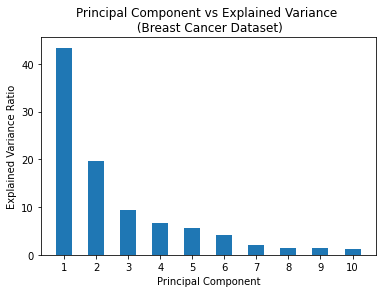

In [1001]:
run_pca_plot_eigen_values(x_train_sc)

#### PCA = 7 Features

## 2.2) ICA

In [1002]:
def run_ica(x_train):
    """
    Run ICA from n_components 1 to N and get average  kurtosis
    """
    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1):    
        transformer = ICA(n_components=num, random_state=1)
        x_transformed = transformer.fit_transform(x_train)

        x_transformed = pd.DataFrame(x_transformed)
        kurtosis = x_transformed.kurtosis(axis=0)
        kurtosis_mean = kurtosis.abs().mean()
        
        data.append(kurtosis_mean)
        print(kurtosis_mean)
        

    plt.title("Number of Components vs Average Kurtosis \n(Breast Cancer Dataset)")
    plt.xlabel("Number of Components")
    plt.ylabel("Average Kurtosis")
    plt.plot(range(1, n+1), data)
    plt.grid()
    plt.axvline(24, linestyle="dotted", color='g')
    
    plt.savefig('images/bc/2.2 Kurtosis.png')
    plt.show()

0.9966876299638496
3.3897492250606565
5.406149429145649
5.415230219448011
7.445496500988307
7.4109203337168035
10.568569732472094
10.274706826617273
13.777010319785317
12.528528260895738
20.566771932520833
20.213388380093495
19.8864940526865
19.339770929473048
20.99305490839481
19.75408149198722
23.694582398739893
24.037110250289032
25.15993276184566
24.07186047277841
27.42101977232737
28.13155463628747
31.037531206840768
32.303390635968974
32.22281120380724
32.22389717823272
32.139322835617165
32.33884870837955
32.91571047717762
32.785433512102756


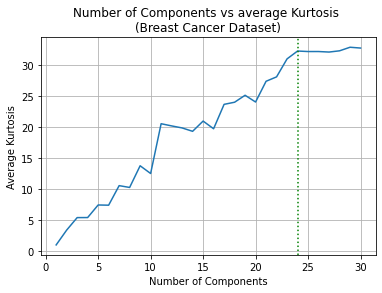

In [1003]:
run_ica(x_train_sc)

####  ICA = 24 Fetures

In [1174]:
def run_ica_2(x_train):
    """
    Run ICA for N n_components kurtosis for each component
    """
    n = x_train_sc.shape[1]  
    transformer = ICA(n_components=n, random_state=1)
    x_transformed = transformer.fit_transform(x_train)
    x_transformed = pd.DataFrame(x_transformed)    
    kurtosis = x_transformed.kurtosis(axis=0)
    print(kurtosis)
    kurtosis_abs = kurtosis.abs()
        
    data = []
    for i, k in enumerate(kurtosis_abs):
        data.append([f"IC{i+1}", k])
    
    p = pd.DataFrame(data, columns=["IC", "Kurtosis"])
    
    # get only top 10 IC    
    p.sort_values(by="Kurtosis", ascending=False, inplace=True)
    
    print(p)
    
    x_labels = p["IC"][:10]
    y_values = p["Kurtosis"][:10]    
    
    plt.title("Average Kurtosis per Component \n (Breast Cancer Dataset)")
    plt.ylabel("Average Kurtosis") 
    plt.bar(x_labels, y_values)
    plt.savefig('images/bc/2.2 Kurtosis per IC.png')
    plt.show()
    


0       5.319324
1      30.395974
2     249.347397
3       9.110305
4       2.742234
5       6.705590
6      36.371168
7       2.741200
8       1.621688
9       6.822335
10      8.936210
11     17.076922
12      4.582964
13    207.711469
14      8.646260
15     28.729292
16      3.861676
17      5.698056
18      2.849086
19     90.071003
20      3.579560
21      3.752915
22     42.381443
23     13.916546
24     45.997824
25     97.212462
26      5.306371
27     12.047651
28     12.548979
29     17.479105
dtype: float64
      IC    Kurtosis
2    IC3  249.347397
13  IC14  207.711469
25  IC26   97.212462
19  IC20   90.071003
24  IC25   45.997824
22  IC23   42.381443
6    IC7   36.371168
1    IC2   30.395974
15  IC16   28.729292
29  IC30   17.479105
11  IC12   17.076922
23  IC24   13.916546
28  IC29   12.548979
27  IC28   12.047651
3    IC4    9.110305
10  IC11    8.936210
14  IC15    8.646260
9   IC10    6.822335
5    IC6    6.705590
17  IC18    5.698056
0    IC1    5.319324
26  IC27    5

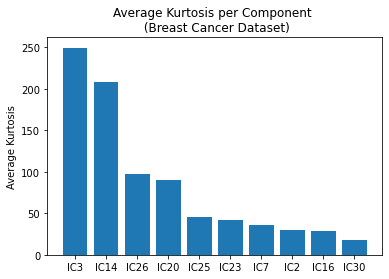

In [1175]:
run_ica_2(x_train_sc)

In [ ]:
#### N=24

In [1177]:
#### 6 ICs to drop
# 21  IC22    3.752915
# 20  IC21    3.579560
# 18  IC19    2.849086
# 4    IC5    2.742234
# 7    IC8    2.741200
# 8    IC9    1.621688

## 2.3 RCA  (Randomized Projection)

In [1017]:
def run_rp(x_train):
    """
    random projection
    """

    n = x_train_sc.shape[1]
    
    # Run 1
    data = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=0)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data.append([num, error])
        
        print(f"{num} error={error}")
       
    # Run 2
    data_2 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=10)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_2.append([num, error])
        
    # Run 3
    data_3 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=20)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_3.append([num, error])
        
    # Run 4
    data_4 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=40)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_4.append([num, error])
        
    # Run 5
    data_5 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=50)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_5.append([num, error])
    
    df = pd.DataFrame(data, columns=["Features", "Reconstruction Error (MSE)"])
    df_2 = pd.DataFrame(data_2, columns=["Features", "Reconstruction Error (MSE)"])
    df_3 = pd.DataFrame(data_3, columns=["Features", "Reconstruction Error (MSE)"])
    df_4 = pd.DataFrame(data_4, columns=["Features", "Reconstruction Error (MSE)"])
    df_5 = pd.DataFrame(data_5, columns=["Features", "Reconstruction Error (MSE)"])
      
    plt.title("Number of Components vs Reconstruction Error \n Breast Cancer: RP")
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)") 
    plt.plot(df["Features"], df["Reconstruction Error (MSE)"], label="random_state=1")
    plt.plot(df_2["Features"], df_2["Reconstruction Error (MSE)"], label="random_state=2")
    plt.plot(df_3["Features"], df_3["Reconstruction Error (MSE)"], label="random_state=3")
    plt.plot(df_4["Features"], df_4["Reconstruction Error (MSE)"], label="random_state=4")
    plt.plot(df_5["Features"], df_5["Reconstruction Error (MSE)"], label="random_state=5")
    
    # Error line
    plt.axhline(0.0959138, linestyle="dotted", color='g')
    plt.axvline(27, linestyle="dotted", color='g')
    
    plt.grid()
    plt.legend()
    plt.savefig('images/bc/2.3 rp reconst error.png')
    plt.show()

1 error=0.9591388869980736
2 error=0.9402563262606025
3 error=0.8997627582750789
4 error=0.7804784445097371
5 error=0.7720018025369867
6 error=0.7398317399772064
7 error=0.6837749139819014
8 error=0.6643771233479747
9 error=0.638833114930472
10 error=0.5965833065858527
11 error=0.5713166734123777
12 error=0.5386771986395035
13 error=0.47834198302005343
14 error=0.4286268960595964
15 error=0.40464821208114027
16 error=0.3855461633381738
17 error=0.36928747357999114
18 error=0.32229227103860636
19 error=0.30987486361945327
20 error=0.2602769995951951
21 error=0.24103065783634556
22 error=0.23176286141676572
23 error=0.218649436904855
24 error=0.1490881012782022
25 error=0.12866219075200863
26 error=0.10561464873869184
27 error=0.059350765649550684
28 error=0.02745783743869112
29 error=0.013707656458000919
30 error=1.3705112033626296e-29


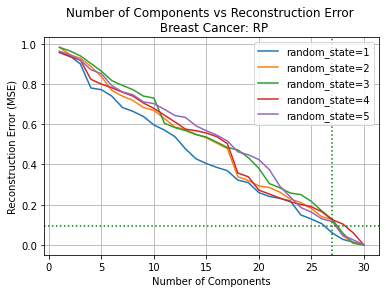

In [1018]:
run_rp(x_train_sc)

In [734]:
# highest error is 0.959138 @ 1 component and lowest error ~0
# pick a threashold of 10% error rate
# 0.959138*(0.1) = 0.0959138 MSE
# we see this at ~26 componenets

#### RP = 26 Features

## 2.4 NCA (Neighborhood Components Analysis)

In [1014]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html

# Neighborhood Components Analysis (NCA) tries to find a feature space 
# such that a stochastic nearest neighbor algorithm will give the best accuracy. 
# Like LDA, it is a supervised method.

# One can see that NCA enforces a clustering of the data that is visually meaningful 

In [1046]:
def run_nca_knn(x_train_sc, y_train):
    
    n = x_train_sc.shape[1]
    data = []
    
    KNN_NEIGHBORS = 5
    knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS)
    
    for num in range(2, n+1):
        nca_model = NCA(n_components=num, random_state=0)
        x_transformed = nca_model.fit_transform(x_train_sc, y_train)
        
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(x_transformed, y_train)
        
        # Compute the nearest neighbor accuracy on the embedded test set
        knn_acc = knn.score(nca_model.transform(x_train_sc), y_train)
        
        print(f"{num} KNN Accuracy={knn_acc}")
        data.append([num, knn_acc])
        
    df = pd.DataFrame(data, columns=["Features", "KNN Accuracy"])

    plt.title("Number of Components vs KNN Accuracy \n (Breast Cancer Dataset)")
    plt.xlabel("Number of Components")
    plt.ylabel("KNN Accuracy") 
    plt.plot(df["Features"], df["KNN Accuracy"])

    plt.axvline(7, linestyle="dotted", color='g')
    
    plt.grid()
    plt.savefig('images/bc/2.4 nca knn acc.png')
    plt.show()

2 KNN Accuracy=0.9868131868131869
3 KNN Accuracy=0.9868131868131869
4 KNN Accuracy=0.989010989010989
5 KNN Accuracy=0.9912087912087912
6 KNN Accuracy=0.989010989010989
7 KNN Accuracy=0.9934065934065934
8 KNN Accuracy=0.9912087912087912
9 KNN Accuracy=0.9868131868131869
10 KNN Accuracy=0.9824175824175824
11 KNN Accuracy=0.9868131868131869
12 KNN Accuracy=0.989010989010989
13 KNN Accuracy=0.989010989010989
14 KNN Accuracy=0.989010989010989
15 KNN Accuracy=0.9868131868131869
16 KNN Accuracy=0.989010989010989
17 KNN Accuracy=0.9868131868131869
18 KNN Accuracy=0.9846153846153847
19 KNN Accuracy=0.9824175824175824
20 KNN Accuracy=0.9824175824175824
21 KNN Accuracy=0.9868131868131869
22 KNN Accuracy=0.978021978021978
23 KNN Accuracy=0.9868131868131869
24 KNN Accuracy=0.9868131868131869
25 KNN Accuracy=0.9824175824175824
26 KNN Accuracy=0.9846153846153847
27 KNN Accuracy=0.9846153846153847
28 KNN Accuracy=0.9846153846153847
29 KNN Accuracy=0.9802197802197802
30 KNN Accuracy=0.9868131868131869


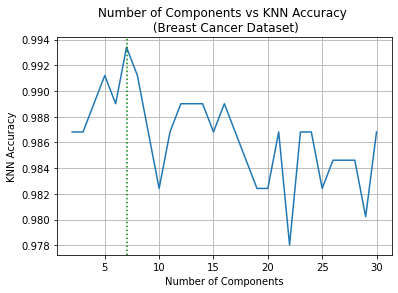

In [1047]:
run_nca_knn(x_train_sc, y_train)

In [1033]:
# def run_nca(x_train, y_train):
#     """
#     Neighborhood Components Analysis
#     """
#     n = x_train_sc.shape[1]
#     data = []
    
#     for num in range(1, n+1):
#         transformer = NCA(n_components=num, random_state=0)
#         x_transformed = transformer.fit_transform(x_train, y_train)
        
#         # Reconstruction
#         inverse_data = np.linalg.pinv(transformer.components_.T)
#         reconstructed_data = x_transformed.dot(inverse_data)
        
#         error = MSE(x_train, reconstructed_data)
        
#         data.append([num, error])
    
#     df = pd.DataFrame(data, columns=["Features", "Reconstruction Error (MSE)"])
   
#     plt.title("Number of Components vs Reconstruction Error \n (Breast Cancer Dataset)")
#     plt.xlabel("Number of Components")
#     plt.ylabel("Reconstruction Error (MSE)") 
#     plt.plot(df["Features"], df["Reconstruction Error (MSE)"])

#     plt.grid()
#     plt.savefig('images/bc/2.4 nca reconst error.png')
#     plt.show()

In [1043]:
# run_nca(x_train_sc, y_train)

In [626]:
# 10% error at 23 features

In [621]:
# def run_lda(x_train, y_train):
#     """
#     Linear Discriminant Analysis
#     """

#     # n_components cannot be larger than min(n_features, n_classes - 1).
    
#     n_features = x_train_sc.shape[1]
#     n_classes = len(np.unique(y_train))
#     n = np.min([n_features, n_classes - 1])
    
#     data = []
    
#     for num in range(1, n+1):
#         clf = LDA(n_components=num)
#         x_transformed = clf.fit_transform(x_train, y_train)


In [ ]:
# run_lda(x_train_sc, y_train)

# 3) DR -> Clustering

- 3.1) PCA -> K-means
- 3.2) PCA -> EM

- 3.3) ICA -> K-means
- 3.4) ICA -> EM

- 3.5) RP -> K-means
- 3.6) RP -> EM

- 3.7) NCA -> K-means
- 3.8) NCA -> EM

## 3.1) PCA -> K-means

In [1228]:
def pca_kmeans_sil_score(x_train_sc):
    # Apply PCA
    pca = PCA(n_components = 7)
    x_transformed = pca.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed)
    
    # Apply Kmeans on PCA x_transformed dataset
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        labels = km.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    pca_kmeans_silhouette_score_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
    return pca_kmeans_silhouette_score_df

In [1229]:
pca_kmeans_sil_df = pca_kmeans_sil_score(x_train_sc)

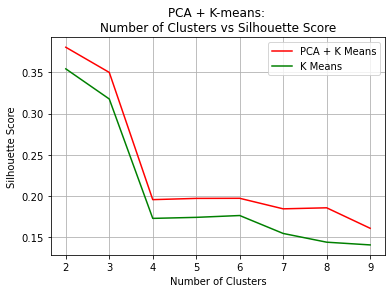

In [845]:
plt.title("PCA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_kmeans_sil_df["Clusters"], pca_kmeans_sil_df["Silhouette Score"], color='r', label='PCA + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.1 pca kmeans sil.png')
plt.show()

In [1310]:
def pca_kmeans_inert_score(x_train_sc):
    # Apply PCA
    pca = PCA(n_components = 7)
    x_transformed = pca.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed)
    
    # Apply Kmeans on PCA x_transformed dataset
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        inert = km.inertia_
        data.append([n, inert])

    pca_kmeans_silhouette_score_df = pd.DataFrame(data, columns=["Clusters", "Inert Score"])
    
    return pca_kmeans_silhouette_score_df

In [1311]:
pca_kmeans_inert_score = pca_kmeans_inert_score(x_train_sc)

## 3.2) PCA -> EM

In [743]:
def pca_em_silhouette_score(x_train_sc):
    pca = PCA(n_components = 7)
    x_transformed = pca.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    pca_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
    return pca_em_sil_df

In [745]:
pca_em_sil_df = pca_em_silhouette_score(x_train_sc)

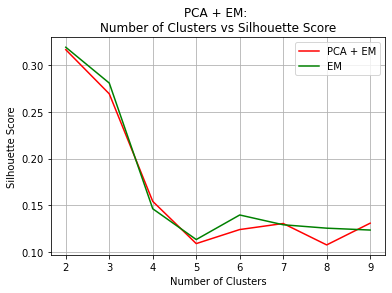

In [846]:
plt.title("PCA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_sil_df["Clusters"], pca_em_sil_df["Silhouette Score"], color='r', label='PCA + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.2 pca em sil.png')
plt.show()

In [756]:
def pca_em_bic_score(x_train_sc):
    pca = PCA(n_components = 7)
    x_transformed = pca.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed)
    
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        bic = gmm.bic(x_transformed)

        data.append([n, bic])

    pca_em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    
    return pca_em_bic_df

In [757]:
pca_em_bic_df = pca_em_bic_score(x_train_sc)

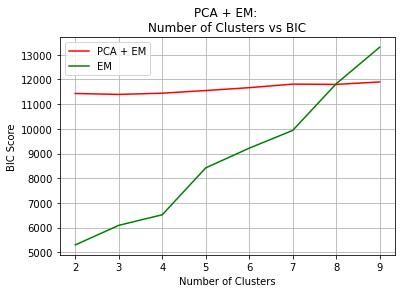

In [848]:
plt.title("PCA + EM: \nNumber of Clusters vs BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(pca_em_bic_df["Clusters"], pca_em_bic_df["BIC Score"], color='r', label='PCA + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.2 pca em BIC.png')
plt.show()

## 3.3) ICA -> K-means

In [1192]:
def ica_kmeans_sil_score(x_train_sc):
    N = x_train_sc.shape[1]
    
    transformer = ICA(n_components=N, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    x_transformed = pd.DataFrame(x_transformed) 
    
    # TO DROP
    # 21, 20, 18, 4, 7, 8
    
    x_transformed.drop([21, 20, 18, 4, 7, 8], axis=1, inplace=True)
    
#     print(x_transformed)

    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        labels = km.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    ica_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
    return ica_kmeans_sil_df

In [1193]:
# def ica_kmeans_sil_score(x_train_sc):
#     transformer = ICA(n_components=24, random_state=1)
#     x_transformed = transformer.fit_transform(x_train_sc)

#     n_clusters=np.arange(2, 10)
#     data=[]

#     for n in n_clusters:
#         km = KMeans(n, random_state=0)
#         km = km.fit(x_transformed)
#         labels = km.predict(x_transformed)
#         sil = silhouette_score(x_transformed, labels, metric='euclidean')

#         data.append([n, sil])

#     ica_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
#     return ica_kmeans_sil_df

In [1194]:
ica_kmeans_sil_df = ica_kmeans_sil_score(x_train_sc)

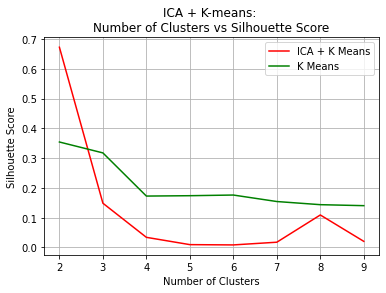

In [1195]:
plt.title("ICA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_kmeans_sil_df["Clusters"], ica_kmeans_sil_df["Silhouette Score"], color='r', label='ICA + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.3 ica kmeans sil.png')
plt.show()

In [1314]:
def ica_kmeans_inert_score(x_train_sc):
    N = x_train_sc.shape[1]
    
    transformer = ICA(n_components=N, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    x_transformed = pd.DataFrame(x_transformed) 
    
    # TO DROP
    # 21, 20, 18, 4, 7, 8
    
    x_transformed.drop([21, 20, 18, 4, 7, 8], axis=1, inplace=True)
    
#     print(x_transformed)

    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        inert = km.inertia_

        data.append([n, inert])

    ica_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Inert Score"])
    
    return ica_kmeans_sil_df

In [1315]:
ica_kmeans_inert_score = ica_kmeans_inert_score(x_train_sc)

## 3.4) ICA -> EM

In [1196]:
def ica_em_sil_score(x_train_sc):
    N = x_train_sc.shape[1]
    transformer = ICA(n_components=N, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    x_transformed = pd.DataFrame(x_transformed) 
    
    # TO DROP
    # 21, 20, 18, 4, 7, 8
    
    x_transformed.drop([21, 20, 18, 4, 7, 8], axis=1, inplace=True)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    ica_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
    return ica_em_sil_df

In [770]:
# def ica_em_sil_score(x_train_sc):
#     transformer = ICA(n_components=24, random_state=1)
#     x_transformed = transformer.fit_transform(x_train_sc)
    
#     n_clusters=np.arange(2, 10)
#     data=[]

#     for n in n_clusters:
#         gmm = GaussianMixture(n, random_state=0)
#         gmm = gmm.fit(x_transformed)
#         labels = gmm.predict(x_transformed)
#         sil = silhouette_score(x_transformed, labels, metric='euclidean')

#         data.append([n, sil])

#     ica_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
#     return ica_em_sil_df

In [1197]:
ica_em_sil_df = ica_em_sil_score(x_train_sc)

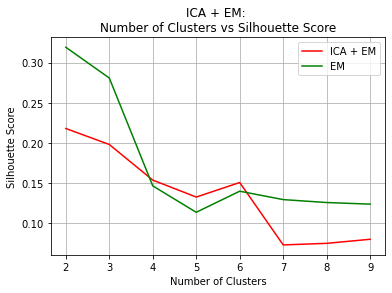

In [1198]:
plt.title("ICA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_em_sil_df["Clusters"], ica_em_sil_df["Silhouette Score"], color='r', label='ICA + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.4 ica em sil.png')
plt.show()

In [1199]:
def ica_em_bic_score(x_train_sc):
    N = x_train_sc.shape[1]
    
    transformer = ICA(n_components=N, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    x_transformed = pd.DataFrame(x_transformed) 
    
    # TO DROP
    # 21, 20, 18, 4, 7, 8
    
    x_transformed.drop([21, 20, 18, 4, 7, 8], axis=1, inplace=True)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        bic = gmm.bic(x_transformed)

        data.append([n, bic])

    ica_em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    
    return ica_em_bic_df

In [1200]:
ica_em_bic_df = ica_em_bic_score(x_train_sc)

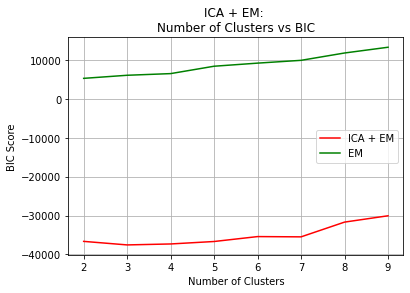

In [1201]:
plt.title("ICA + EM: \nNumber of Clusters vs BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(ica_em_bic_df["Clusters"], ica_em_bic_df["BIC Score"], color='r', label='ICA + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.4 ica em BIC.png')
plt.show()

## 3.5) RP -> K-means

In [779]:
def rp_kmeans_sil_score(x_train_sc):
    transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)

    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        labels = km.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    rp_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return rp_kmeans_sil_df

In [781]:
rp_kmeans_sil_df = rp_kmeans_sil_score(x_train_sc)

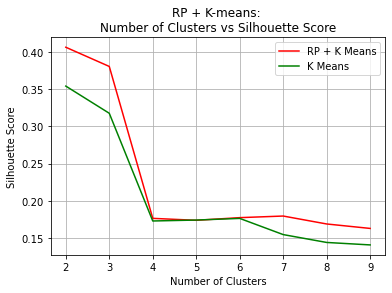

In [852]:
plt.title("RP + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(rp_kmeans_sil_df["Clusters"], rp_kmeans_sil_df["Silhouette Score"], color='r', label='RP + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.5 rp kmeans sil.png')
plt.show()

In [1316]:
def rp_kmeans_inert_score(x_train_sc):
    transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)

    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        inert = km.inertia_

        data.append([n, inert])

    rp_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Inert Score"])
    return rp_kmeans_sil_df

In [1317]:
rp_kmeans_inert_score = rp_kmeans_inert_score(x_train_sc)

## 3.6) RP -> EM

In [783]:
def rp_em_sil_score(x_train_sc):
    transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    rp_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return rp_em_sil_df

In [784]:
rp_em_sil_df = rp_em_sil_score(x_train_sc)

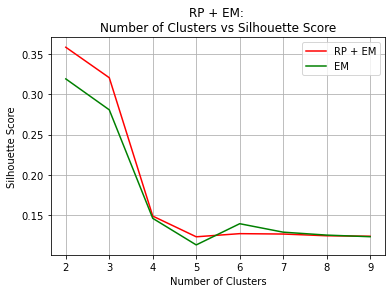

In [854]:
plt.title("RP + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(rp_em_sil_df["Clusters"], rp_em_sil_df["Silhouette Score"], color='r', label='RP + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.6 rp em sil.png')
plt.show()

In [786]:
def rp_em_bic_score(x_train_sc):
    transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        bic = gmm.bic(x_transformed)
    
        data.append([n, bic])

    rp_em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    return rp_em_bic_df

In [787]:
rp_em_bic_df = rp_em_bic_score(x_train_sc)

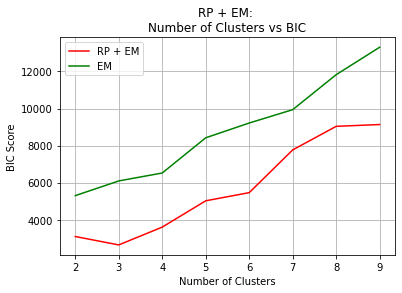

In [855]:
plt.title("RP + EM: \nNumber of Clusters vs BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(rp_em_bic_df["Clusters"], rp_em_bic_df["BIC Score"], color='r', label='RP + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.6 rp kmeans bic.png')
plt.show()

## 3.7) NCA -> K-means

In [397]:
# clf = LDA(n_components=1)
# x_transformed = clf.fit_transform(x_train_sc, y_train)

In [1072]:
def nca_kmeans_sil_score(x_train_sc):
    transformer = NCA(n_components=7, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)
    
    print(x_transformed.shape)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        labels = km.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    nca_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return nca_kmeans_sil_df
    

In [1073]:
nca_kmeans_sil_df = nca_kmeans_sil_score(x_train_sc)

(455, 7)


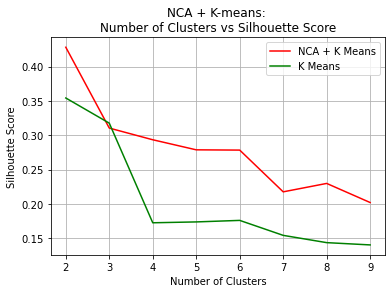

In [1074]:
plt.title("NCA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(nca_kmeans_sil_df["Clusters"], nca_kmeans_sil_df["Silhouette Score"], color='r', label='NCA + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.7 nca kmeans sil.png')
plt.show()

In [1318]:
def nca_kmeans_inert_score(x_train_sc):
    transformer = NCA(n_components=7, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)
    
    print(x_transformed.shape)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        inert = km.inertia_

        data.append([n, inert])

    nca_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Inert Score"])
    return nca_kmeans_sil_df
    

In [1319]:
nca_kmeans_inert_score = nca_kmeans_inert_score(x_train_sc)

(455, 7)


## 3.8) NCA -> EM

In [400]:
# clf = LDA(n_components=1)
# x_transformed = clf.fit_transform(x_train_sc, y_train)

In [1075]:
def nca_em_sil_score(x_train_sc):
    transformer = NCA(n_components=7, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    nca_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return nca_em_sil_df

In [1076]:
nca_em_sil_df = nca_em_sil_score(x_train_sc)

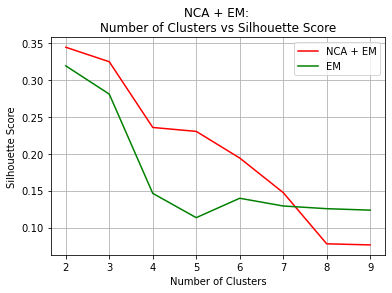

In [1077]:
plt.title("NCA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(nca_em_sil_df["Clusters"], nca_em_sil_df["Silhouette Score"], color='r', label='NCA + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.8 nca em sil.png')
plt.show()

In [1078]:
def nca_em_bic_score(x_train_sc):
    transformer = NCA(n_components=7, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        bic = gmm.bic(x_transformed)

        data.append([n, bic])

    nca_em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    return nca_em_bic_df

In [1079]:
nca_em_bic_df = nca_em_bic_score(x_train_sc)

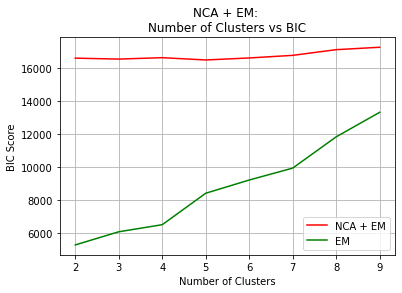

In [1080]:
plt.title("NCA + EM: \nNumber of Clusters vs BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(nca_em_bic_df["Clusters"], nca_em_bic_df["BIC Score"], color='r', label='NCA + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.8 nca em bic.png')
plt.show()

## 3) All in One

#### All DRs + Kmeans

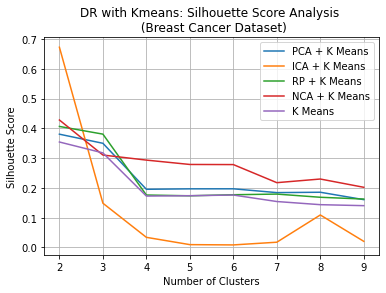

In [1202]:
plt.title("DR with Kmeans: Silhouette Score Analysis \n (Breast Cancer Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_kmeans_sil_df["Clusters"], pca_kmeans_sil_df["Silhouette Score"], label='PCA + K Means')
plt.plot(ica_kmeans_sil_df["Clusters"], ica_kmeans_sil_df["Silhouette Score"], label='ICA + K Means')
plt.plot(rp_kmeans_sil_df["Clusters"], rp_kmeans_sil_df["Silhouette Score"], label='RP + K Means')
plt.plot(nca_kmeans_sil_df["Clusters"], nca_kmeans_sil_df["Silhouette Score"], label='NCA + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], label='K Means')

plt.legend()
plt.grid()
plt.savefig('images/bc/3.9 all DRs with Kmeans sil.png')
plt.show()

### Elbow Plots

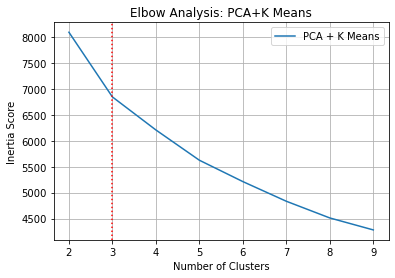

In [1348]:
plt.title("Elbow Analysis: PCA+K Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score") 

plt.plot(pca_kmeans_inert_score["Clusters"], pca_kmeans_inert_score["Inert Score"], label='PCA + K Means')
plt.axvline(3, linestyle="dotted", color='r')

plt.legend()
plt.grid()
plt.savefig('images/bc/10 elbow.png')
plt.show()

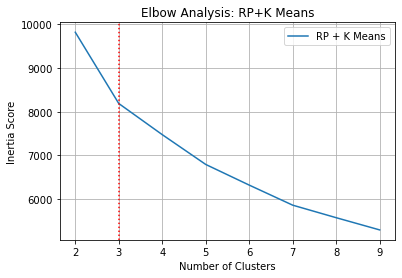

In [1349]:
plt.title("Elbow Analysis: RP+K Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score") 

plt.plot(rp_kmeans_inert_score["Clusters"], rp_kmeans_inert_score["Inert Score"], label='RP + K Means')
plt.axvline(3, linestyle="dotted", color='r')

plt.legend()
plt.grid()
plt.savefig('images/bc/11 elbow.png')
plt.show()

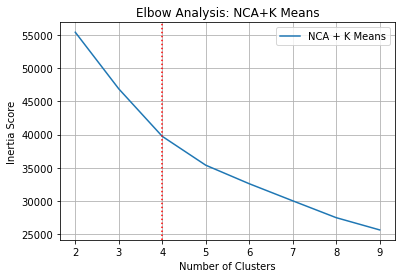

In [1350]:
plt.title("Elbow Analysis: NCA+K Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score") 

plt.plot(nca_kmeans_inert_score["Clusters"], nca_kmeans_inert_score["Inert Score"], label='NCA + K Means')
plt.axvline(4, linestyle="dotted", color='r')

plt.legend()
plt.grid()
plt.savefig('images/bc/12 elbow.png')
plt.show()

#### All DRs + EM

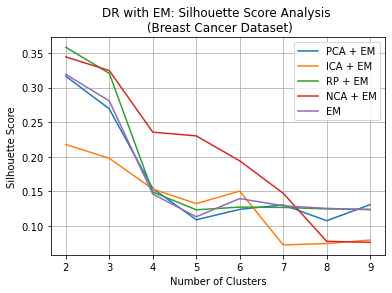

In [1203]:
plt.title("DR with EM: Silhouette Score Analysis \n (Breast Cancer Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_sil_df["Clusters"], pca_em_sil_df["Silhouette Score"], label='PCA + EM')
plt.plot(ica_em_sil_df["Clusters"], ica_em_sil_df["Silhouette Score"], label='ICA + EM')
plt.plot(rp_em_sil_df["Clusters"], rp_em_sil_df["Silhouette Score"], label='RP + EM')
plt.plot(nca_em_sil_df["Clusters"], nca_em_sil_df["Silhouette Score"], label='NCA + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], label='EM')

plt.legend()
plt.grid()
plt.savefig('images/bc/3.9 all DRs with EM sil.png')
plt.show()

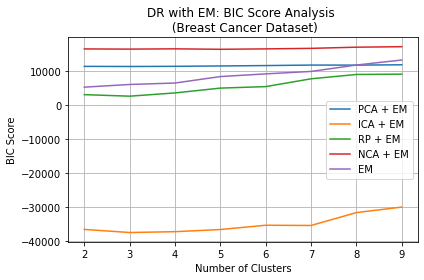

In [1204]:
plt.title("DR with EM: BIC Score Analysis \n (Breast Cancer Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(pca_em_bic_df["Clusters"], pca_em_bic_df["BIC Score"], label='PCA + EM')
plt.plot(ica_em_bic_df["Clusters"], ica_em_bic_df["BIC Score"], label='ICA + EM')
plt.plot(rp_em_bic_df["Clusters"], rp_em_bic_df["BIC Score"], label='RP + EM')
plt.plot(nca_em_bic_df["Clusters"], nca_em_bic_df["BIC Score"], label='NCA + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], label='EM')

plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig('images/bc/3.9 all DRs with EM BIC.png')
plt.show()

### Sil scores and Accuracies

In [1467]:
def pca_kmean_acc(x_train_sc, y_train):
    pca = PCA(n_components = 7, random_state=0)
    x_transformed = pca.fit_transform(x_train_sc)

    km = KMeans(n_clusters=3, random_state=0)
    labels = km.fit_predict(x_transformed)

    clustering_accuracy = accuracy_score(labels, y_train)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    print(f"pca_kmean_sil={sil}  acc = {clustering_accuracy}")


def ica_kmean_acc(x_train_sc, y_train):
    N = x_train_sc.shape[1]
    transformer = ICA(n_components=N, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed) 
    x_transformed.drop([21, 20, 18, 4, 7, 8], axis=1, inplace=True)


    km = KMeans(n_clusters=2, random_state=0)
    labels = km.fit_predict(x_transformed)

    clustering_accuracy = accuracy_score(labels, y_train)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    print(f"ica_kmean_sil={sil}  acc = {clustering_accuracy}")


def rp_kmeans_acc(x_train_sc, y_train):
    transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)

    km = KMeans(n_clusters=3, random_state=0)
    labels = km.fit_predict(x_transformed)

    clustering_accuracy = accuracy_score(labels, y_train)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    print(f"rp_kmeans_sil={sil}  acc = {clustering_accuracy}")


def nca_kmeans_acc(x_train_sc, y_train):
    transformer = NCA(n_components=7, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)

    km = KMeans(n_clusters=4, random_state=0)
    labels = km.fit_predict(x_transformed)

    clustering_accuracy = accuracy_score(labels, y_train)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    print(f"nca_kmeans_sil={sil}  acc = {clustering_accuracy}")


def pca_em_acc(x_train_sc, y_train):
    pca = PCA(n_components = 7, random_state=0)
    x_transformed = pca.fit_transform(x_train_sc)

    gmm = GaussianMixture(n_components=2, random_state=0)
    labels = gmm.fit_predict(x_transformed)

    clustering_accuracy = accuracy_score(labels, y_train)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    print(f"pca_em_sil={sil}  acc = {clustering_accuracy}")

    
def ica_em_acc(x_train_sc, y_train):
    N = x_train_sc.shape[1]
    transformer = ICA(n_components=N, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed) 
    x_transformed.drop([21, 20, 18, 4, 7, 8], axis=1, inplace=True)


    gmm = GaussianMixture(n_components=3, random_state=0)
    labels = gmm.fit_predict(x_transformed)

    clustering_accuracy = accuracy_score(labels, y_train)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    print(f"ica_em_sil={sil}  acc = {clustering_accuracy}")
    
def rp_em_acc(x_train_sc, y_train):
    transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)

    gmm = GaussianMixture(n_components=2, random_state=0)
    labels = gmm.fit_predict(x_transformed)

    clustering_accuracy = accuracy_score(labels, y_train)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    print(f"rp_em_sil={sil}  acc = {clustering_accuracy}")
    
def nca_em_acc(x_train_sc, y_train):
    transformer = NCA(n_components=7, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)

    gmm = GaussianMixture(n_components=4, random_state=0)
    labels = gmm.fit_predict(x_transformed)

    clustering_accuracy = accuracy_score(labels, y_train)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    print(f"nca_em_sil={sil}  acc = {clustering_accuracy}")


In [1460]:
pca_kmean_acc(x_train_sc, y_train)
ica_kmean_acc(x_train_sc, y_train)
rp_kmeans_acc(x_train_sc, y_train)
nca_kmeans_acc(x_train_sc, y_train)

pca_kmean_sil=0.3251881690715863  acc = 0.778021978021978
ica_kmean_sil=0.652215993346744  acc = 0.6351648351648351
rp_kmeans_sil=0.33283026734589044  acc = 0.7868131868131868
nca_kmeans_sil=0.1806327194662292  acc = 0.6021978021978022


In [1468]:
pca_em_acc(x_train_sc, y_train)
ica_em_acc(x_train_sc, y_train)
rp_em_acc(x_train_sc, y_train)
nca_em_acc(x_train_sc, y_train)

pca_em_sil=0.2934953080094679  acc = 0.8725274725274725
ica_em_sil=0.23967586127026472  acc = 0.5648351648351648
rp_em_sil=0.3136101934125458  acc = 0.9296703296703297
nca_em_sil=0.15912640318984148  acc = 0.16923076923076924


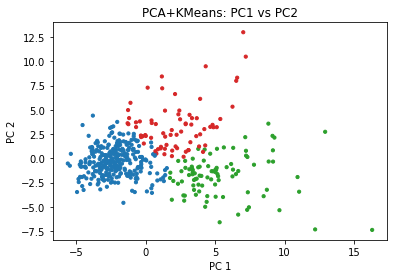

In [1402]:
def pca_kmean_pplot(x_train_sc, y_train):
    pca = PCA(n_components = 7, random_state=2)
    x_transformed = pca.fit_transform(x_train_sc)
    
    km = KMeans(n_clusters=3, random_state=1)
    labels = km.fit_predict(x_transformed)

    # pairplot
    data = pd.DataFrame(x_transformed)
    data = data.iloc[:, :3]
    data["labels"] = labels
    
    colors = ['tab:red','tab:green','tab:blue','tab:orange']
    plt.scatter(data[0], data[1], c=data["labels"].apply(lambda x: colors[x]), s=10)
    
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("PCA+KMeans: PC1 vs PC2")
    
    plt.savefig('images/bc/20.1 pair plot.png')
    
    plt.show()

pca_kmean_pplot(x_train_sc, y_train)

pca_em_acc = 0.4


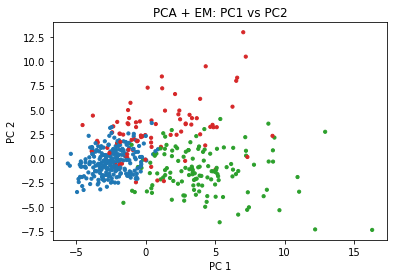

In [1404]:
def pca_em_pplot(x_train_sc, y_train):
    pca = PCA(n_components = 7, random_state=2)
    x_transformed = pca.fit_transform(x_train_sc)

    gmm = GaussianMixture(n_components=3, random_state=2)
    labels = gmm.fit_predict(x_transformed)
    
    # pairplot
    data = pd.DataFrame(x_transformed)
    data = data.iloc[:, :3]
    data["labels"] = labels
    
    colors = ['tab:red','tab:green','tab:blue','tab:orange']
    plt.scatter(data[0], data[1], c=data["labels"].apply(lambda x: colors[x]), s=10)
    
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("PCA + EM: PC1 vs PC2")
    
    plt.savefig('images/bc/20.2 pair plot.png')
    
pca_em_pplot(x_train_sc, y_train)

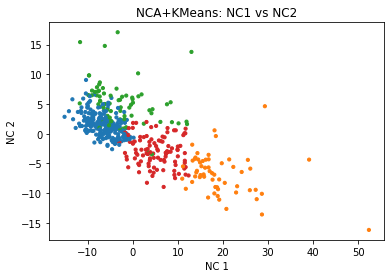

In [1427]:
def nca_kmeans_pplot(x_train_sc, y_train):
    transformer = NCA(n_components=7, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)

    km = KMeans(n_clusters=4, random_state=1)
    labels = km.fit_predict(x_transformed)

    # pairplot
    data = pd.DataFrame(x_transformed)
    data = data.iloc[:, :3]
    data["labels"] = labels
    
    colors = ['tab:green','tab:blue', 'tab:red','tab:orange']
    plt.scatter(data[0], data[1], c=data["labels"].apply(lambda x: colors[x]), s=10)
    
    plt.xlabel("NC 1")
    plt.ylabel("NC 2")
    plt.title("NCA+KMeans: NC1 vs NC2")
    
    plt.savefig('images/bc/20.3 pair plot.png')
    
    plt.show()
    
nca_kmeans_pplot(x_train_sc, y_train)

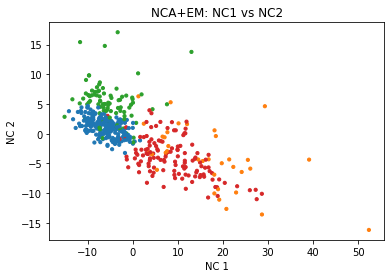

In [1424]:
def nca_em_pplot(x_train_sc, y_train):
    transformer = NCA(n_components=7, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)

    gmm = GaussianMixture(n_components=4, random_state=1)
    labels = gmm.fit_predict(x_transformed)

    # pairplot
    data = pd.DataFrame(x_transformed)
    data = data.iloc[:, :3]
    data["labels"] = labels
    
    colors = ['tab:blue','tab:orange', 'tab:red','tab:green']
    plt.scatter(data[0], data[1], c=data["labels"].apply(lambda x: colors[x]), s=10)
    
    plt.xlabel("NC 1")
    plt.ylabel("NC 2")
    plt.title("NCA+EM: NC1 vs NC2")
    
    plt.savefig('images/bc/20.4 pair plot.png')
    
    plt.show()
    
    
nca_em_pplot(x_train_sc, y_train)

# 4) DR -> NN

- 4.1) PCA -> NN
- 4.2) ICA -> NN
- 4.3) RP -> NN
- 4.4) NCA -> NN

In [1106]:
def nn_per_epoch(X, y, activation, alpha, hidden_layer_size, max_epoches, title=None, save_as=None):
    epochs = []
    train_scores = []
    val_scores = []
    
    for epoch in range(10, max_epoches+1, 20):
        mlp_clf = MLPClassifier(
            hidden_layer_sizes=hidden_layer_size,
            activation=activation, 
            alpha=alpha, 
            max_iter=epoch,
            random_state=0
        )
        
        val_score = cross_val_score(
            estimator=mlp_clf,
            X=X,
            y=y,
            scoring="accuracy",
            cv=10
        )
        val_score = val_score.mean()
        
        mlp_clf.fit(X, y)
        train_score = mlp_clf.score(X, y)
        
        val_scores.append(val_score)
        train_scores.append(train_score)
        
        epochs.append(epoch)

    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("Score")

    plt.plot(epochs, train_scores, label="Training score", color="r")
    plt.plot(epochs, val_scores, label="Cross-validation score", color="g")


    plt.legend(loc="best")
    plt.grid()
    
    if save_as:
        plt.savefig('images/bc/'+save_as)
    
    plt.show()

In [428]:
def plot_model_curve(estimator, title, X, y, param_name, param_range, cv=10, n_jobs=None, x_scale_is_log=False):
    """
    https://scikit-learn.org/0.15/auto_examples/plot_validation_curve.html
    """
    
    train_scores, test_scores = validation_curve(
        estimator, 
        X, 
        y, 
        param_name=param_name, 
        param_range=param_range,
        cv=cv, 
        scoring="balanced_accuracy", 
        n_jobs=n_jobs
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    
    if x_scale_is_log:
        plt.xscale('log')

    plt.plot(param_range, train_scores_mean, label="Training score", color="r")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

    plt.legend(loc="best")

    return plt

In [433]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=10,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring="balanced_accuracy",
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Training time of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    print("Train accuracy:", train_scores_mean[-1])
    print("Validation accuracy:", test_scores_mean[-1])
    print("Train Time:", fit_times_mean[-1])
    
    return plt

## 4.1) PCA -> NN

In [1110]:
pca = PCA(n_components = 7)
x_train_transformed = pca.fit_transform(x_train_sc)
x_test_transformed = pca.transform(x_test_sc)

x_train_transformed = pd.DataFrame(x_train_transformed)
x_test_transformed = pd.DataFrame(x_test_transformed)

#### Check with A1 network

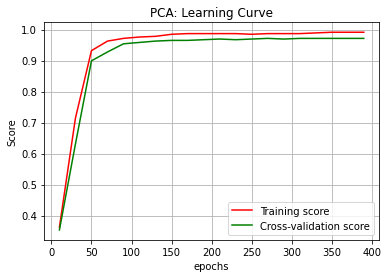

In [1112]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.01,
    hidden_layer_size=(12, 12),
    max_epoches=400,
    title="PCA: Learning Curve",
    save_as="4.1 pca nn.png"
)

#### Tune hyper params: Alpha

In [503]:
# param_range = np.logspace(-3, 1, 20)

# nn_clf = MLPClassifier(
#     hidden_layer_sizes=(12, 12),
#     activation='relu',
#     max_iter=300,
#     random_state=0
# )

# plot_model_curve(
#     estimator=nn_clf,
#     title="alpha vs score",
#     X=x_train_transformed,
#     y=y_train,
#     param_name="alpha",
#     param_range=param_range,
#     cv=10,
#     x_scale_is_log=True
# )

Train accuracy: 0.9626155468929131
Validation accuracy: 0.951717799188641
Train Time: 0.2461874008178711


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

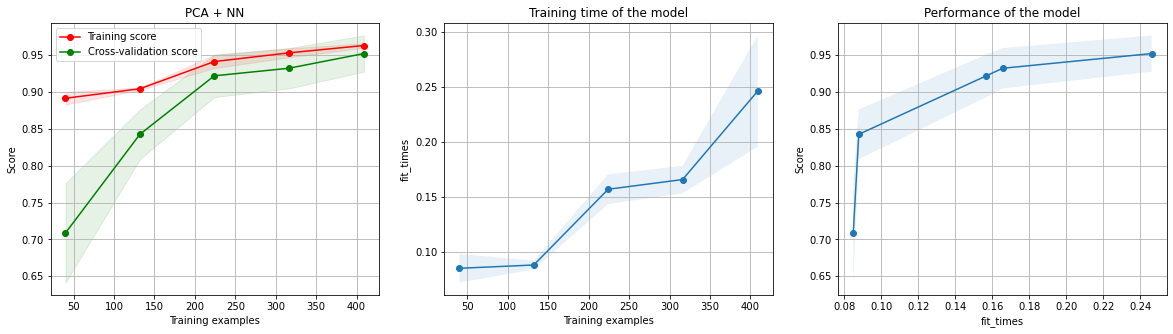

In [510]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=110,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="PCA + NN", 
    X=x_train_transformed, 
    y=y_train,
    cv=10
)

In [514]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=110,
    random_state=0
)

final_nn_clf.fit(x_train_transformed, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_transformed)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.0021719932556152344
Test Accuracy: 0.9736842105263158


## 4.2) ICA -> NN

In [1215]:
N = x_train_sc.shape[1]

transformer = ICA(n_components=N, random_state=1)
x_train_transformed = transformer.fit_transform(x_train_sc)
x_test_transformed = transformer.transform(x_test_sc)

In [1216]:
x_train_transformed = pd.DataFrame(x_train_transformed)
x_test_transformed = pd.DataFrame(x_test_transformed)

In [1217]:
x_train_transformed.drop([21, 20, 18, 4, 7, 8], axis=1, inplace=True)
x_test_transformed.drop([21, 20, 18, 4, 7, 8], axis=1, inplace=True)

#### check with A1 NN

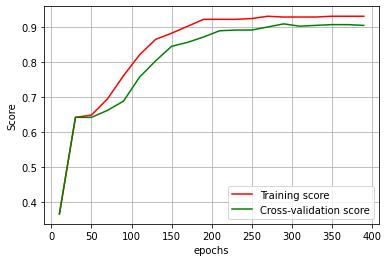

In [1219]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.01,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

In [1221]:
# nn_per_epoch(
#     X=x_train_transformed, 
#     y=y_train, 
#     activation='relu',
#     alpha=0.01,
#     hidden_layer_size=(12, 12),
#     max_epoches=400
# )

In [519]:
# nn_per_epoch(
#     X=x_train_transformed, 
#     y=y_train, 
#     activation='relu',
#     alpha=0.01,
#     hidden_layer_size=(12, 12),
#     max_epoches=400
# )

#### Tune Alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

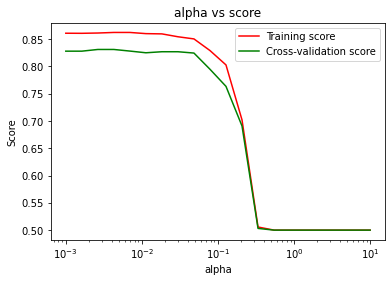

In [1222]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=200,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_transformed,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.8582687275779153
Validation accuracy: 0.8342545638945232
Train Time: 0.6493939161300659


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

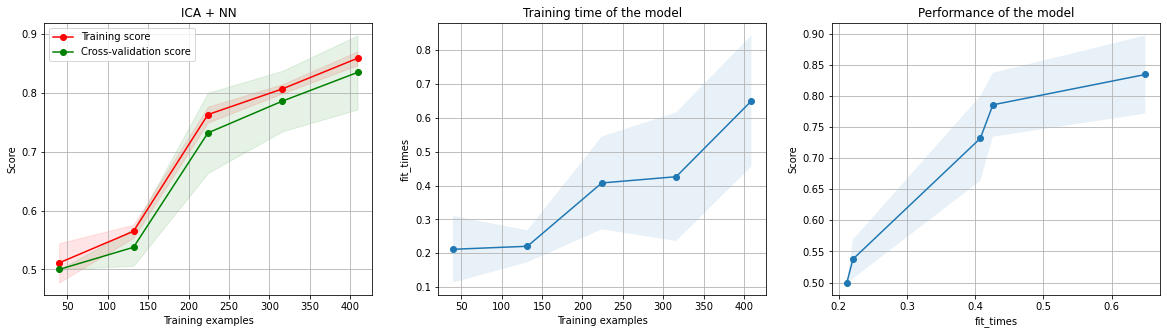

In [1223]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.01, 
    max_iter=200,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="ICA + NN", 
    X=x_train_transformed, 
    y=y_train,
    cv=10
)

In [1224]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.01, 
    max_iter=200,
    random_state=0
)

final_nn_clf.fit(x_train_transformed, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_transformed)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.0031180381774902344
Test Accuracy: 0.8859649122807017


In [496]:
# print(classification_report(y_test, dt_y_preds))

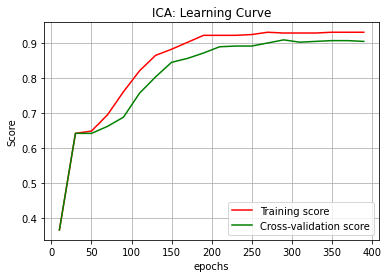

In [1225]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.01,
    hidden_layer_size=(12, 12),
    max_epoches=400,
    title="ICA: Learning Curve",
    save_as="4.2 ica nn.png"
)

## 4.3) RP -> NN

In [1122]:
transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
x_train_transformed = transformer.fit_transform(x_train_sc)
x_test_transformed = transformer.transform(x_test_sc)

In [1123]:
x_train_transformed = pd.DataFrame(x_train_transformed)
x_test_transformed = pd.DataFrame(x_test_transformed)

#### check with A1 NN

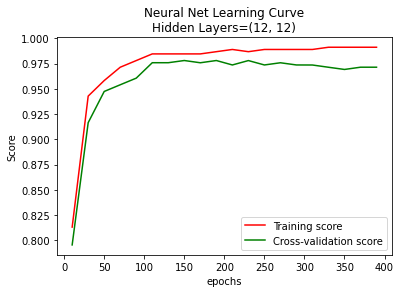

In [560]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.1,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

#### Tune alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

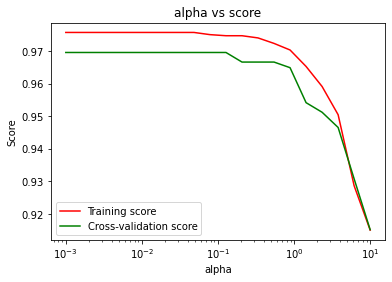

In [561]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=125,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_transformed,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.9753209974345127
Validation accuracy: 0.9678055273833671
Train Time: 0.3499213695526123


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

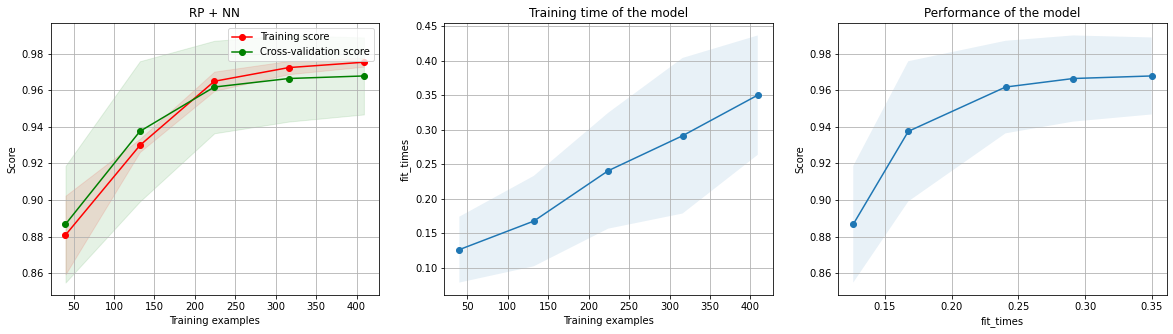

In [562]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=125,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="RP + NN", 
    X=x_train_transformed, 
    y=y_train,
    cv=10
)

In [563]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=125,
    random_state=0
)

final_nn_clf.fit(x_train_transformed, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_transformed)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.002710103988647461
Test Accuracy: 0.9385964912280702


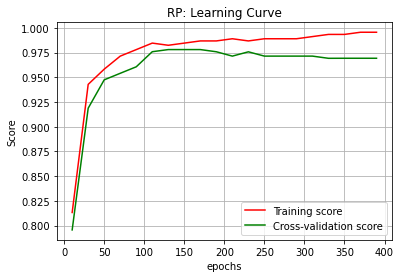

In [1124]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.01,
    hidden_layer_size=(12, 12),
    max_epoches=400,
    title="RP: Learning Curve",
    save_as="4.3 rp nn.png"
)

## 4.4) NCA -> NN

In [1125]:
transformer = NCA(n_components=7, random_state=0)
x_train_transformed = transformer.fit_transform(x_train_sc, y_train)
x_test_transformed = transformer.transform(x_test_sc)

In [1126]:
x_train_transformed = pd.DataFrame(x_train_transformed)
x_test_transformed = pd.DataFrame(x_test_transformed)

#### check with A1 NN

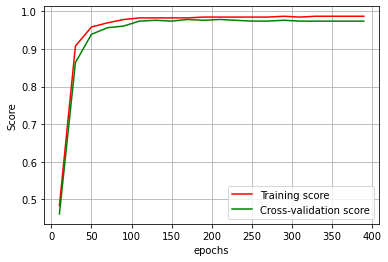

In [1127]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.1,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

#### Tune alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

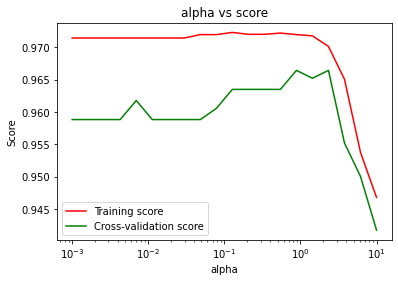

In [1128]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=100,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_transformed,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.9712367742210372
Validation accuracy: 0.9617837221095336
Train Time: 0.26422843933105467


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

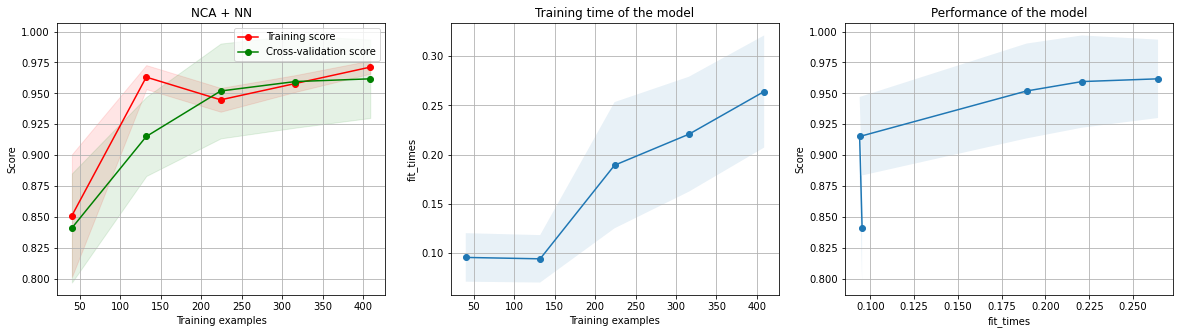

In [1129]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.8, 
    max_iter=100,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="NCA + NN", 
    X=x_train_transformed, 
    y=y_train,
    cv=10
)

In [1130]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.8, 
    max_iter=100,
    random_state=0
)

final_nn_clf.fit(x_train_transformed, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_transformed)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.002560853958129883
Test Accuracy: 0.9473684210526315


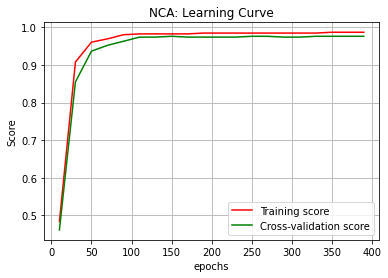

In [1131]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.8,
    hidden_layer_size=(12, 12),
    max_epoches=400,
    title="NCA: Learning Curve",
    save_as="4.4 nca nn.png"
)

# 5) Clustering + NN

- 5.1) Kmeans + NN
- 5.2) EM + NN

## 5.1) Kmeans + NN

In [1494]:
km = KMeans(2, random_state=0)
km = km.fit(x_train_sc)

train_labels = km.predict(x_train_sc)
test_labels = km.predict(x_test_sc)

In [1495]:
x_train_kmeans = pd.DataFrame(x_train_sc)
x_test_kmeans = pd.DataFrame(x_test_sc)

In [1496]:
x_train_kmeans['kmean_clusters'] = train_labels
x_test_kmeans['kmean_clusters'] = test_labels

#### check with A1 NN

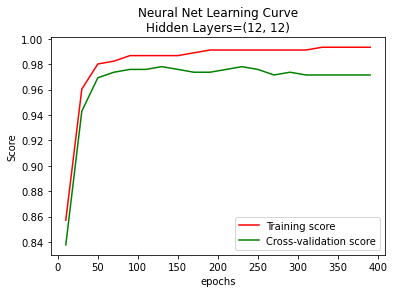

In [585]:
nn_per_epoch(
    X=x_train_kmeans, 
    y=y_train, 
    activation='relu',
    alpha=0.1,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

In [587]:
# nn_per_epoch(
#     X=x_train_kmeans, 
#     y=y_train, 
#     activation='relu',
#     alpha=0.01,
#     hidden_layer_size=(12, 12),
#     max_epoches=400
# )

#### Tune alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

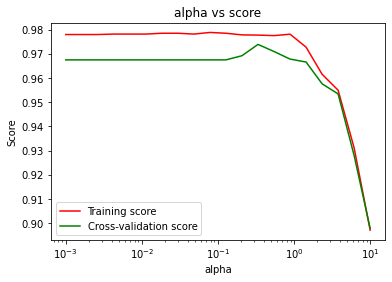

In [588]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=75,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_kmeans,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.9822490497368997
Validation accuracy: 0.9738717038539553
Train Time: 0.5699057817459107


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

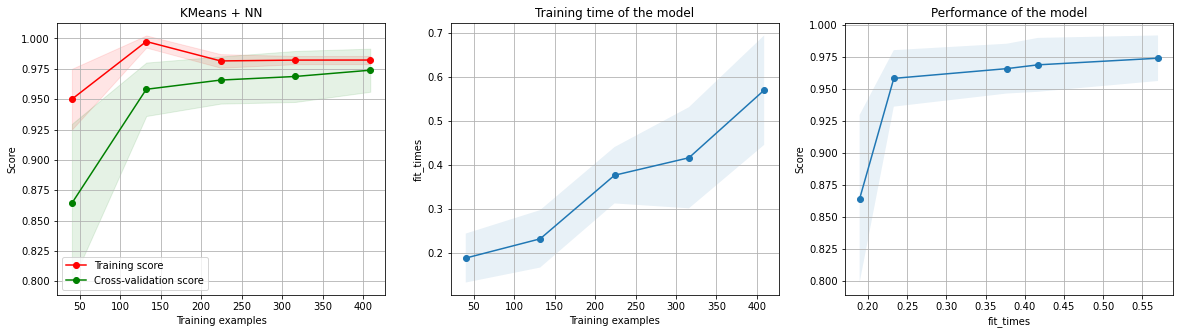

In [1497]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.5, 
    max_iter=200,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="KMeans + NN", 
    X=x_train_kmeans, 
    y=y_train,
    cv=10
)

In [1498]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.5, 
    max_iter=200,
    random_state=0
)

final_nn_clf.fit(x_train_kmeans, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_kmeans)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.0023632049560546875
Test Accuracy: 0.956140350877193


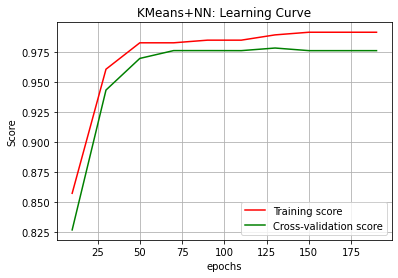

In [1499]:
nn_per_epoch(
    X=x_train_kmeans, 
    y=y_train, 
    activation='relu',
    alpha=0.5,
    hidden_layer_size=(12, 12),
    max_epoches=200,
    title="KMeans+NN: Learning Curve",
    save_as="7.1 kmeans nn.png"
)

## 5.2) EM + NN

In [1505]:
gmm = GaussianMixture(2, random_state=0)
gmm = gmm.fit(x_train_sc)

train_labels = gmm.predict(x_train_sc)
test_labels = gmm.predict(x_test_sc)

In [1506]:
x_train_em = pd.DataFrame(x_train_sc)
x_test_em = pd.DataFrame(x_test_sc)

In [1507]:
x_train_em['em_clusters'] = train_labels
x_test_em['em_clusters'] = test_labels

#### Check with A1 NN

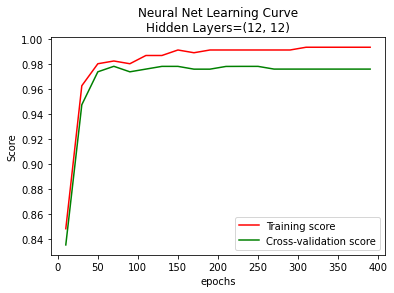

In [605]:
nn_per_epoch(
    X=x_train_em, 
    y=y_train, 
    activation='relu',
    alpha=0.1,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

#### Tune alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

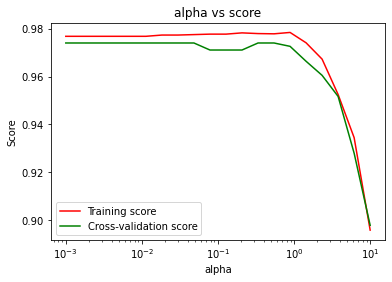

In [609]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=75,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_em,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.9810439653421602
Validation accuracy: 0.970930527383367
Train Time: 0.6297544240951538


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

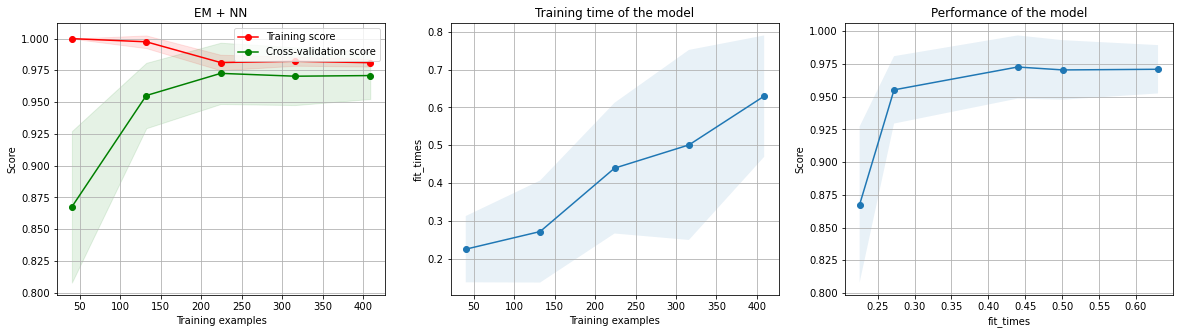

In [1508]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.5, 
    max_iter=200,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="EM + NN", 
    X=x_train_em, 
    y=y_train,
    cv=10
)

In [1509]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.5, 
    max_iter=200,
    random_state=0
)

# final_nn_clf = MLPClassifier(
#     hidden_layer_sizes=(12, 12),
#     activation='relu', 
#     alpha=0.1, 
#     max_iter=75,
#     random_state=0
# )


final_nn_clf.fit(x_train_em, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_em)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.0025908946990966797
Test Accuracy: 0.9824561403508771


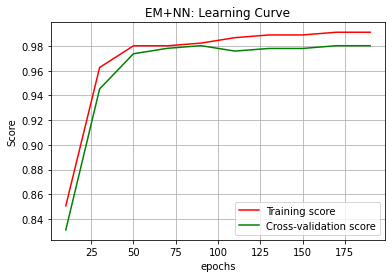

In [1510]:
nn_per_epoch(
    X=x_train_em, 
    y=y_train, 
    activation='relu',
    alpha=0.5,
    hidden_layer_size=(12, 12),
    max_epoches=200,
    title="EM+NN: Learning Curve",
    save_as="7.2 em nn.png"
)

## Original NN from A1

Train accuracy: 0.9753618975998053
Validation accuracy: 0.9712538032454361
Train Time: 0.5294134378433227


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

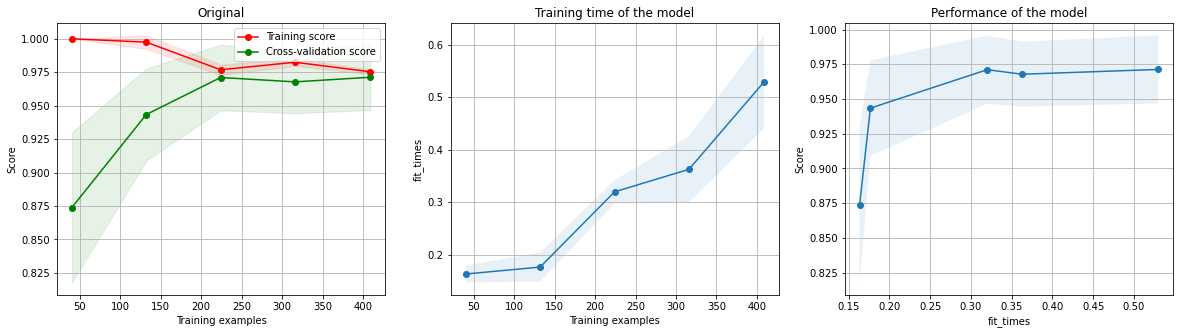

In [1504]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.9, 
    max_iter=200,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="Original", 
    X=x_train_sc, 
    y=y_train,
    cv=10
)

In [1432]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.9, 
    max_iter=200,
    random_state=0
)

final_nn_clf.fit(x_train_sc, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_sc)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.00043511390686035156
Test Accuracy: 0.9649122807017544
